In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns

In [2]:
!gsutil cp gs://cs181_practical_data/Xtrain_amp.npy ./
!gsutil cp gs://cs181_practical_data/ytrain_amp.npy ./

!gsutil cp gs://cs181_practical_data/Xtest_amp.npy ./
!gsutil cp gs://cs181_practical_data/ytest_amp.npy ./

!gsutil cp gs://cs181_practical_data/Xtrain_mel.npy ./
!gsutil cp gs://cs181_practical_data/ytrain_mel.npy ./

!gsutil cp gs://cs181_practical_data/Xtest_mel.npy ./
!gsutil cp gs://cs181_practical_data/ytest_mel.npy ./

Copying gs://cs181_practical_data/Xtrain_amp.npy...
\ [1 files][934.2 MiB/934.2 MiB]   37.5 MiB/s                                   
Operation completed over 1 objects/934.2 MiB.                                    
Copying gs://cs181_practical_data/ytrain_amp.npy...
- [1 files][ 43.5 KiB/ 43.5 KiB]                                                
Operation completed over 1 objects/43.5 KiB.                                     
Copying gs://cs181_practical_data/Xtest_amp.npy...
- [1 files][369.6 MiB/369.6 MiB]                                                
Operation completed over 1 objects/369.6 MiB.                                    
Copying gs://cs181_practical_data/ytest_amp.npy...
- [1 files][ 17.3 KiB/ 17.3 KiB]                                                
Operation completed over 1 objects/17.3 KiB.                                     
Copying gs://cs181_practical_data/Xtrain_mel.npy...
| [1 files][235.9 MiB/235.9 MiB]                                                
Operation

In [3]:
X_amp_train = np.load("Xtrain_amp.npy")
y_amp_train = np.load("ytrain_amp.npy")
X_amp_test = np.load("Xtest_amp.npy")
y_amp_test = np.load("ytest_amp.npy")
X_mel_train = np.load("Xtrain_mel.npy")
y_mel_train = np.load("ytrain_mel.npy")
X_mel_train_flat = X_mel_train.reshape(X_mel_train.shape[0], -1)
X_mel_test = np.load("Xtest_mel.npy")
X_mel_test_flat = X_mel_test.reshape(X_mel_test.shape[0], -1)
y_mel_test = np.load("ytest_mel.npy")

In [ ]:
# Neural Networks w/ Mel
# setting our device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# create a model
model = nn.Sequential(
    nn.Conv1d(in_channels=128, out_channels=16, kernel_size=3),
    nn.MaxPool1d(2),
    nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3),
    nn.MaxPool1d(2),
    # dropout layer to randomly drop neurons: for regularization
    nn.Dropout(),
    nn.Flatten(1),
    ## end with three linear layers, this is general practice
    nn.Linear(640, 400),
    nn.Linear(400, 100),
    nn.Linear(100, 10)
)
# moving the model to right device
model.to(device)

# specify our loss function - CrossEntropyLoss. DO NOT INPUT PROBABILITIES!
loss_func = nn.CrossEntropyLoss()

# define our optimizer - could also do Adam, RMSprop, SGD, and tell it to keep track of our model's parameters.
# the lr is for learning rate, and weight_decay is a regularization parameter.
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
train_accuracy_list = []
train_loss_list = []
test_accuracy_list = []
test_loss_list = []

for epoch in tqdm(range(2000), desc="Epoch"):
    train_inputs = torch.tensor(X_mel_train).float()
    train_labels = torch.tensor(y_mel_train).long()
    train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

    optimizer.zero_grad()
    outputs = model(train_inputs)
    loss = loss_func(outputs, train_labels)
    loss.backward()
    optimizer.step()

    train_loss_list.append(loss.item())

    with torch.no_grad():
        train_preds = torch.argmax(outputs.data, 1)
        train_accuracy = torch.sum(train_preds == train_labels) / train_labels.shape[0]
        train_accuracy_list.append(train_accuracy.item())

        test_inputs = torch.tensor(X_mel_test).float()
        test_labels = torch.tensor(y_mel_test).long()
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        test_outputs = model(test_inputs)
        test_loss = loss_func(test_outputs, test_labels)
        test_loss_list.append(test_loss.item())

        test_preds = torch.argmax(test_outputs.data, 1)
        test_accuracy = torch.sum(test_preds == test_labels) / test_labels.shape[0]
        test_accuracy_list.append(test_accuracy.item())

Epoch: 100%|██████████| 2000/2000 [07:21<00:00,  4.53it/s]


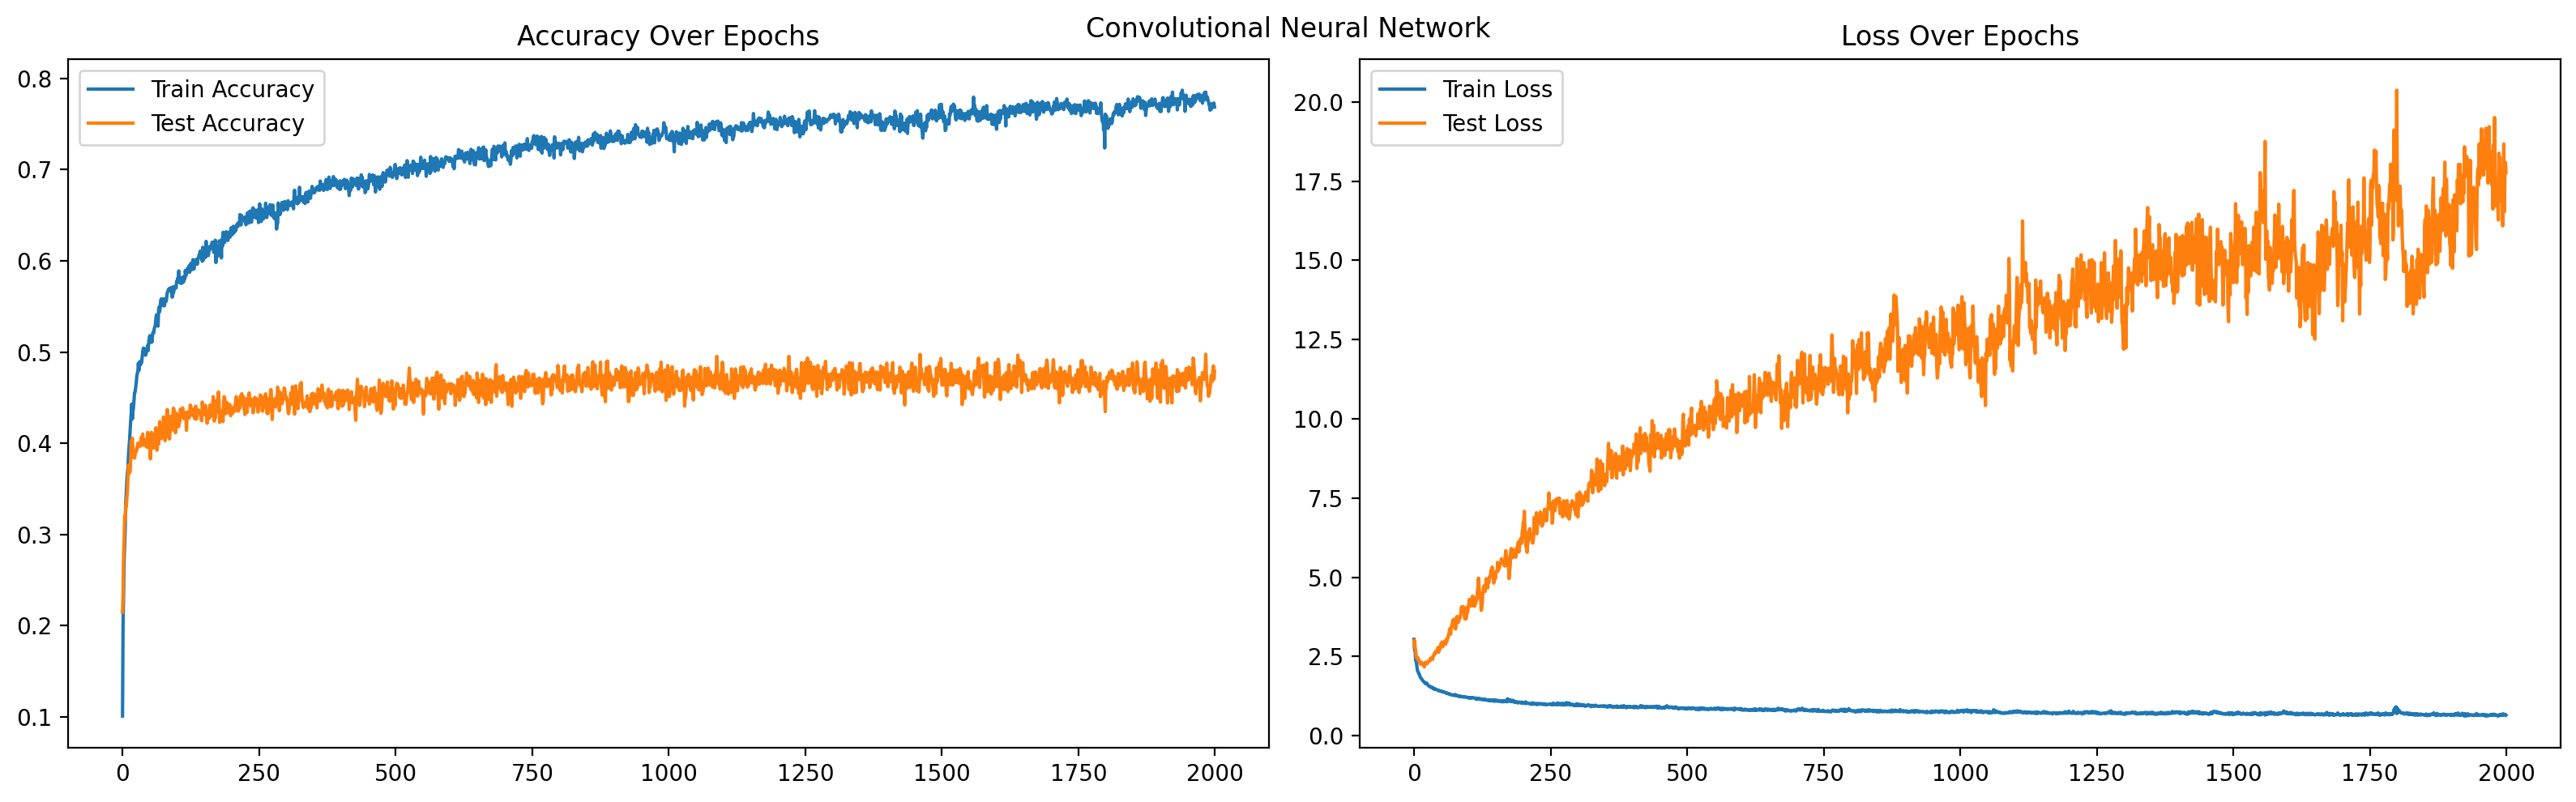

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), dpi=200)

ax[0].plot(train_accuracy_list, label="Train Accuracy")
ax[0].plot(test_accuracy_list, label="Test Accuracy")
ax[0].set_title("Accuracy Over Epochs")
ax[0].legend()

ax[1].plot(train_loss_list, label="Train Loss")
ax[1].plot(test_loss_list, label="Test Loss")
ax[1].set_title("Loss Over Epochs")
ax[1].legend()

plt.suptitle("Convolutional Neural Network")
plt.tight_layout()
plt.show()

In [4]:
def train(k1, p1, k2, p2, iters):
    c1 = 87 - (k1 - 1)
    c2 = c1 // p1 - (k2 - 1)
    final = (c2 // p2) * 32
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = nn.Sequential(
        nn.Conv1d(in_channels=128, out_channels=16, kernel_size=k1),
        nn.MaxPool1d(p1),
        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=k2),
        nn.MaxPool1d(p2),
        nn.Dropout(),
        nn.Flatten(1),
        nn.Linear(final, 400),
        nn.Linear(400, 100),
        nn.Linear(100, 10)
    )
    model.to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    train_accuracy_list = []
    train_loss_list = []
    test_accuracy_list = []
    test_loss_list = []

    for epoch in tqdm(range(iters), desc="Epoch"):
        train_inputs = torch.tensor(X_mel_train).float()
        train_labels = torch.tensor(y_mel_train).long()
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

        optimizer.zero_grad()
        outputs = model(train_inputs)
        loss = loss_func(outputs, train_labels)
        loss.backward()
        optimizer.step()

        train_loss_list.append(loss.item())

        with torch.no_grad():
            train_preds = torch.argmax(outputs.data, 1)
            train_accuracy = torch.sum(train_preds == train_labels) / train_labels.shape[0]
            train_accuracy_list.append(train_accuracy.item())

            test_inputs = torch.tensor(X_mel_test).float()
            test_labels = torch.tensor(y_mel_test).long()
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

            test_outputs = model(test_inputs)
            test_loss = loss_func(test_outputs, test_labels)
            test_loss_list.append(test_loss.item())

            test_preds = torch.argmax(test_outputs.data, 1)
            test_accuracy = torch.sum(test_preds == test_labels) / test_labels.shape[0]
            test_accuracy_list.append(test_accuracy.item())
    return (model, train_accuracy_list, train_loss_list, test_accuracy_list, test_loss_list)

Epoch: 100%|██████████| 250/250 [00:53<00:00,  4.64it/s]


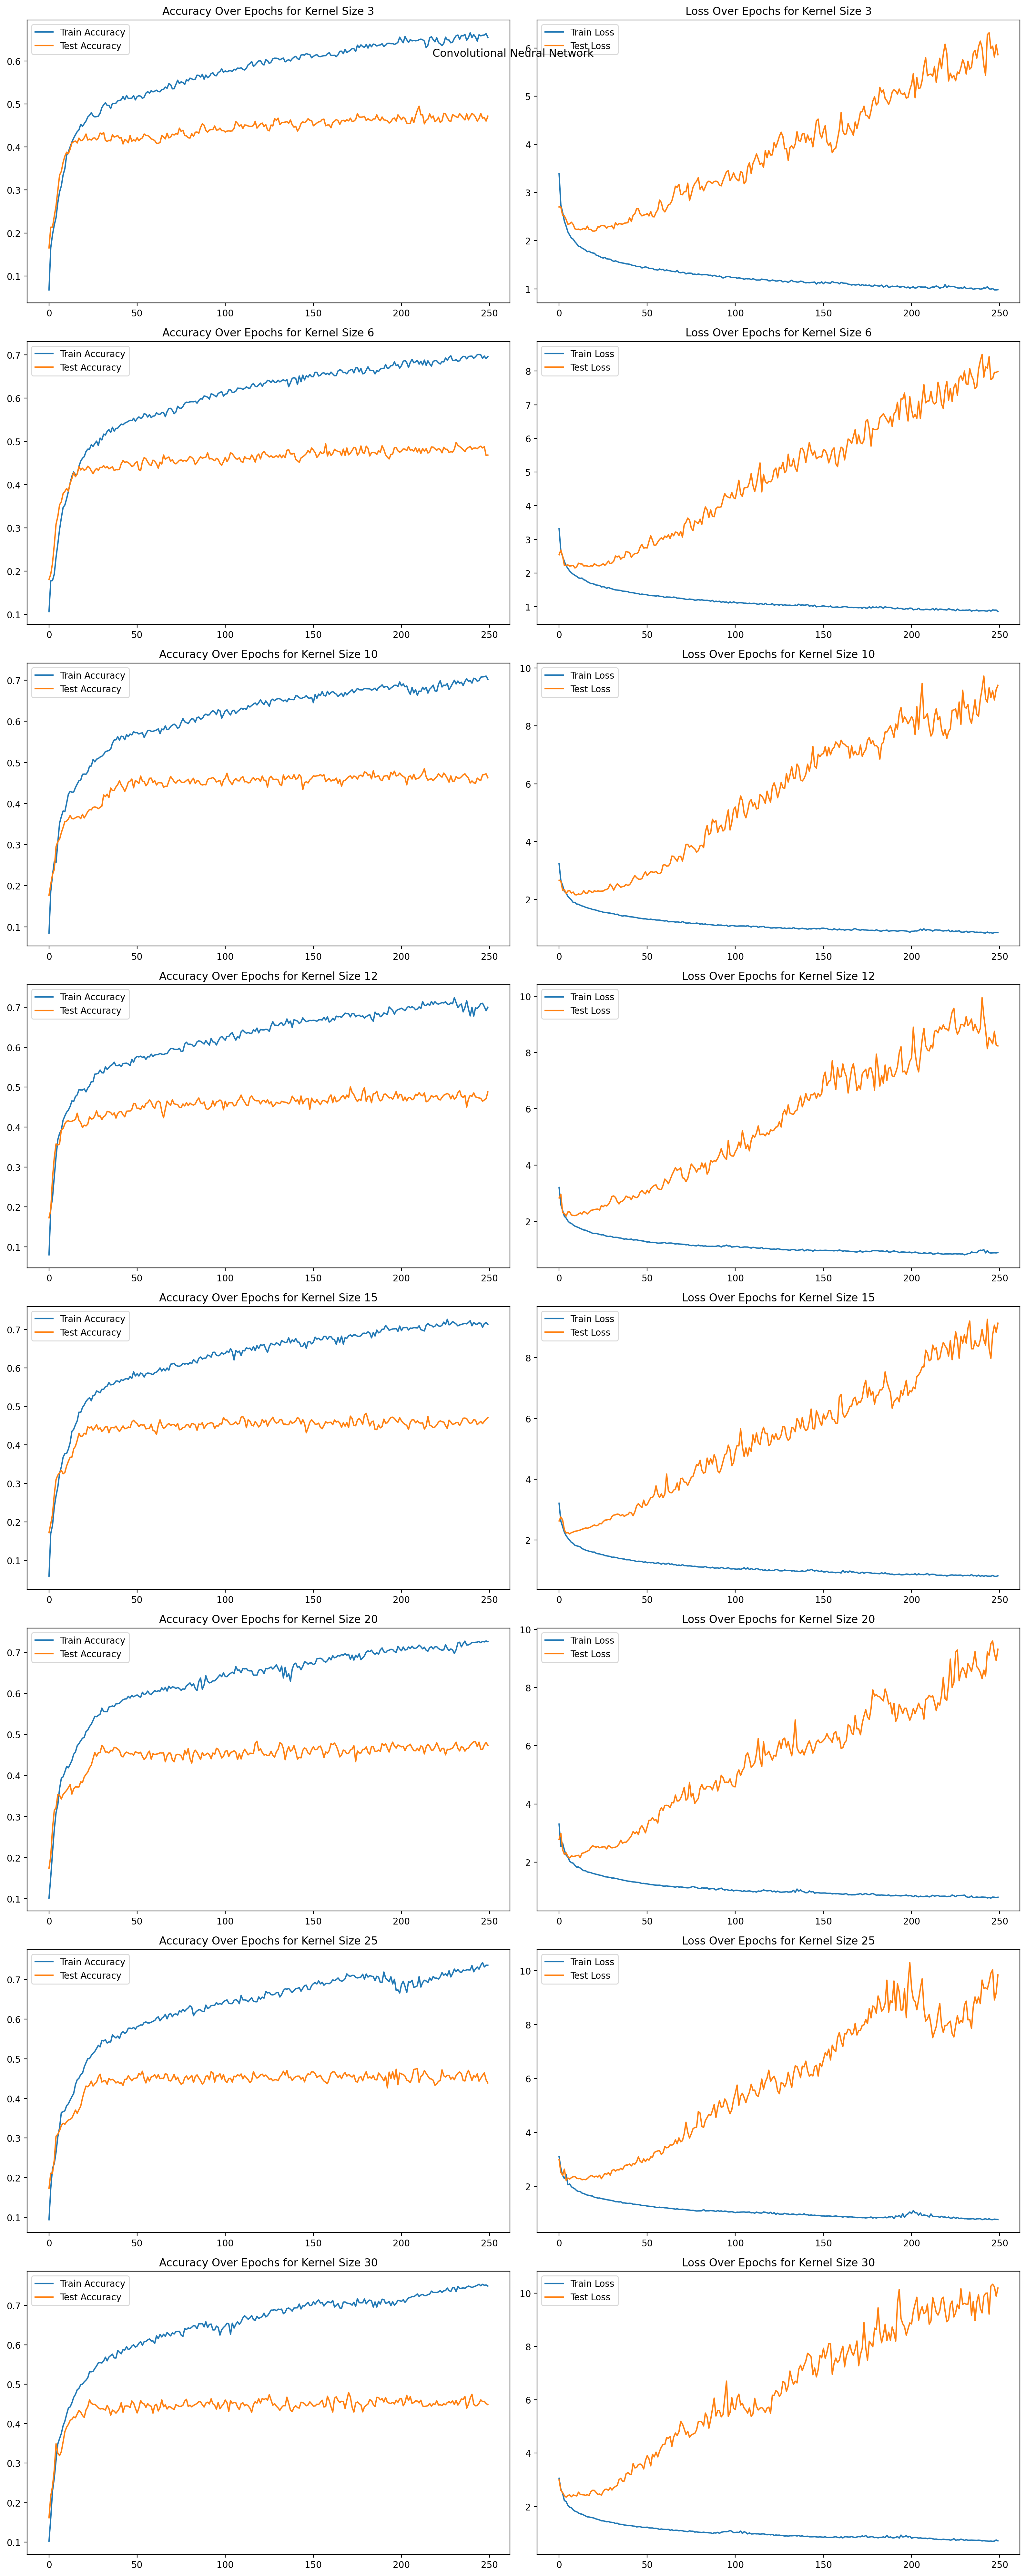

In [5]:
saved = dict()
sizes = [3, 6, 10, 12, 15, 20, 25, 30]
fig, ax = plt.subplots(len(sizes), 2, figsize=(16, 5 * len(sizes)), dpi=200)
for i, s in enumerate(sizes):
    s2 = max(3, min(5, s // 2))
    saved[s] = train(s, 3, s2, 3, 250)
    model, train_accuracy_list, train_loss_list, test_accuracy_list, test_loss_list = saved[s]

    ax[i, 0].plot(train_accuracy_list, label="Train Accuracy")
    ax[i, 0].plot(test_accuracy_list, label="Test Accuracy")
    ax[i, 0].set_title(f"Accuracy Over Epochs for Kernel Size {s}")
    ax[i, 0].legend()

    ax[i, 1].plot(train_loss_list, label="Train Loss")
    ax[i, 1].plot(test_loss_list, label="Test Loss")
    ax[i, 1].set_title(f"Loss Over Epochs for Kernel Size {s}")
    ax[i, 1].legend()

plt.suptitle("Convolutional Neural Network")
plt.show()

In [ ]:
class_accuracies = dict()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for s in sizes:
    model = saved[s][0]
    train_accuracies = []
    test_accuracies = []
    for i in range(10):
        with torch.no_grad():
            train_inputs = torch.tensor(X_mel_train[y_mel_train == i]).float()
            train_labels = torch.tensor(y_mel_train[y_mel_train == i]).long()
            train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
            outputs = model(train_inputs)
            train_preds = torch.argmax(outputs.data, 1)
            train_accuracy = torch.sum(train_preds == train_labels) / train_labels.shape[0]
            train_accuracy = train_accuracy.item()

            test_inputs = torch.tensor(X_mel_test[y_mel_test == i]).float()
            test_labels = torch.tensor(y_mel_test[y_mel_test == i]).long()
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_outputs = model(test_inputs)
            test_preds = torch.argmax(test_outputs.data, 1)
            test_accuracy = torch.sum(test_preds == test_labels) / test_labels.shape[0]
            test_accuracy = test_accuracy.item()
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
    class_accuracies[s] = {'Train': train_accuracies, 'Test': test_accuracies}

In [18]:
train_arr = np.array([class_accuracies[s]['Train'] for s in sizes[::-1]])
test_arr = np.array([class_accuracies[s]['Test'] for s in sizes[::-1]])

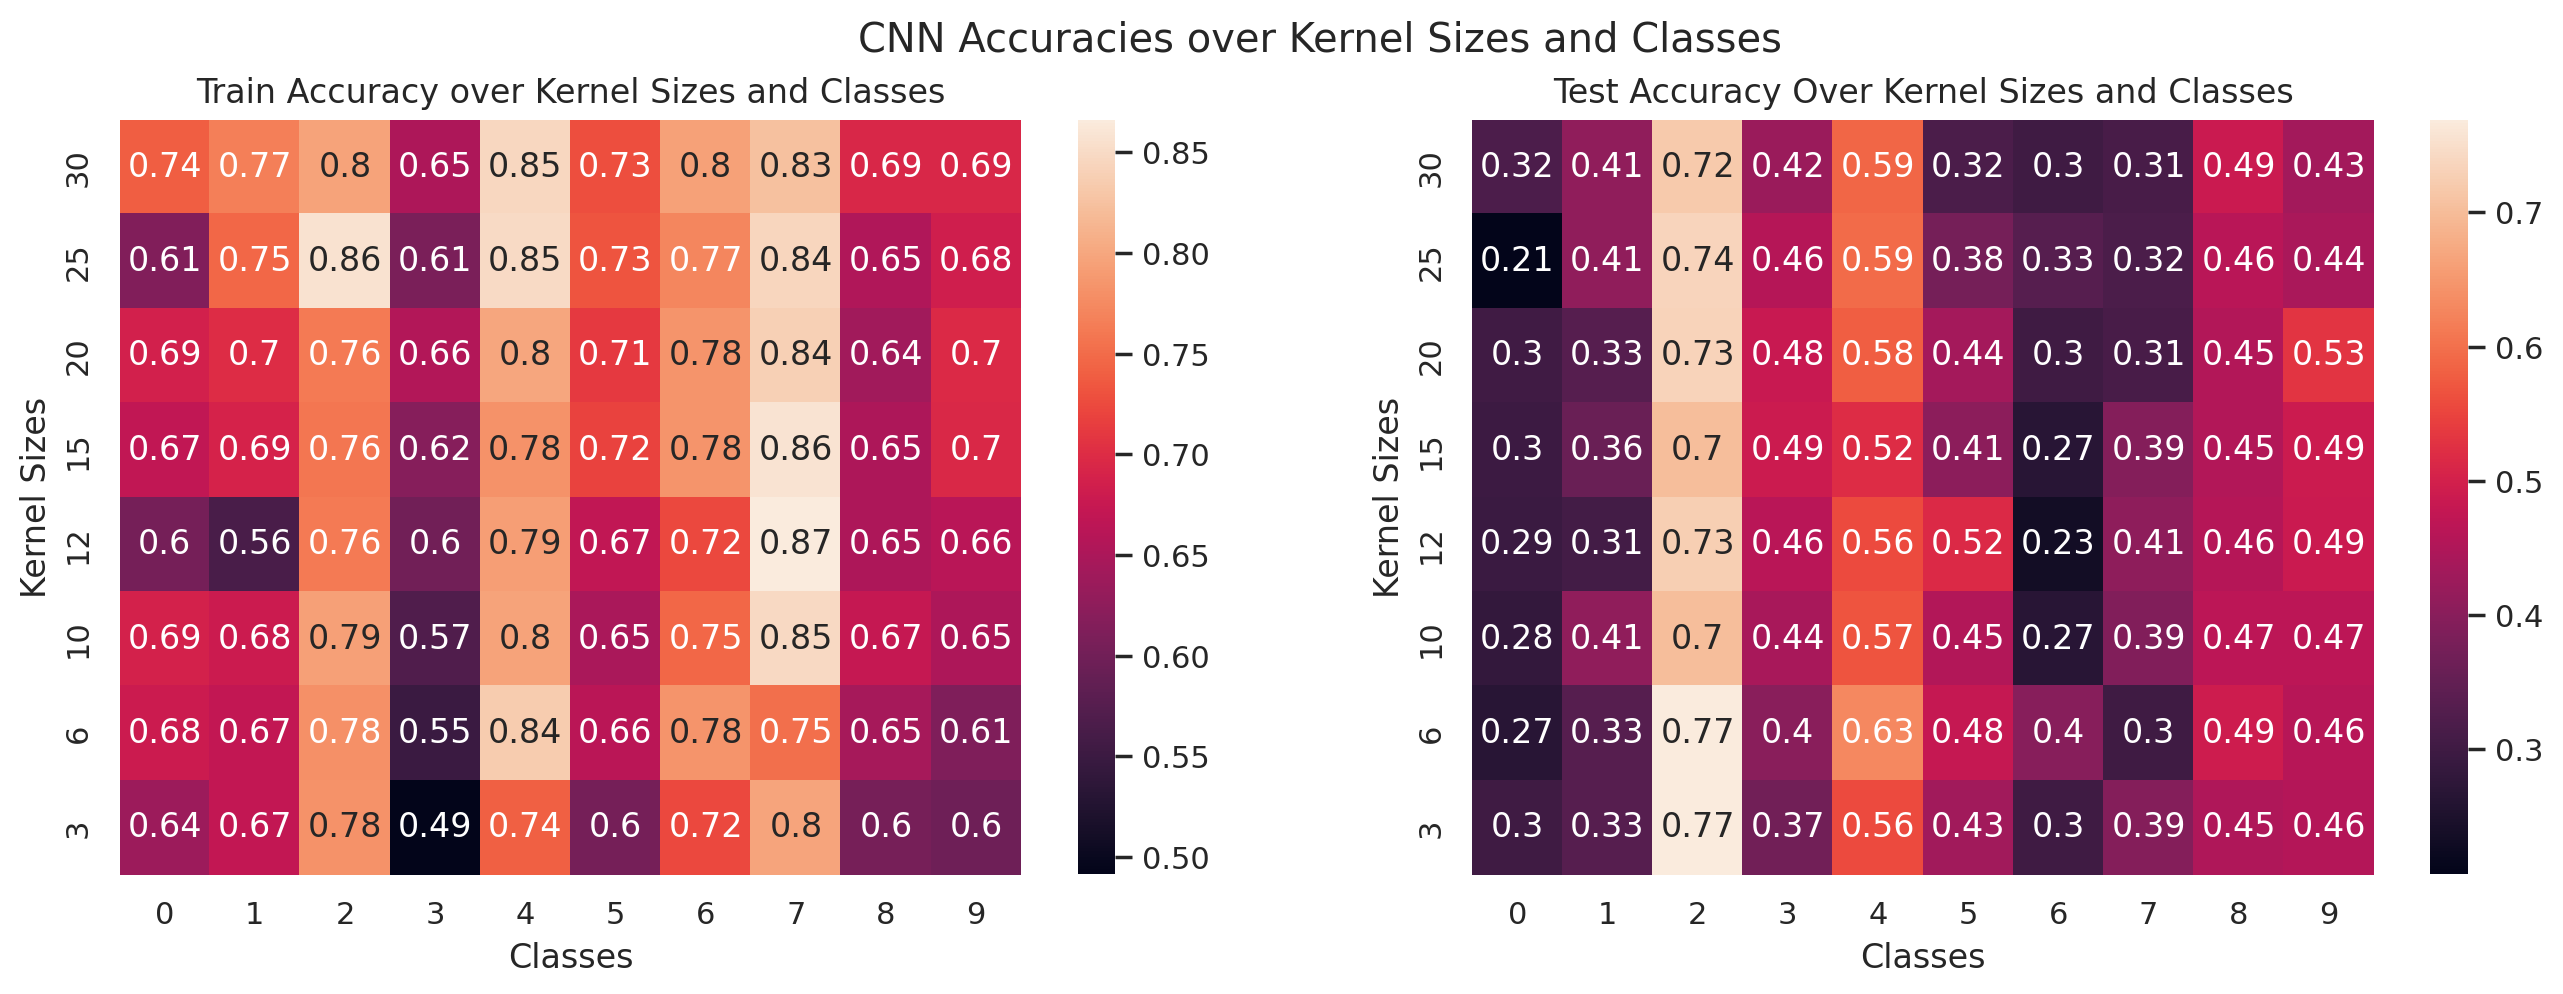

In [27]:
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(16, 5), dpi=200)
ax[0].set_title("Train Accuracy over Kernel Sizes and Classes")
ax[1].set_title("Test Accuracy Over Kernel Sizes and Classes")
h1 = sns.heatmap(data = train_arr, ax = ax[0], yticklabels = sizes[::-1], annot = True)
h2 = sns.heatmap(data = test_arr, ax = ax[1], yticklabels = sizes[::-1], annot = True)
h1.set_xlabel("Classes")
h1.set_ylabel("Kernel Sizes")
h2.set_xlabel("Classes")
h2.set_ylabel("Kernel Sizes")
plt.suptitle("CNN Accuracies over Kernel Sizes and Classes")
plt.show()